#Stock Price Prediction
Stock Price Prediction using machine learning helps you discover the future value of company stock and other financial assets traded on an exchange. The entire idea of predicting stock prices is to gain significant profits. Predicting how the stock market will perform is a hard task to do. There are other factors involved in the prediction, such as physical and psychological factors, rational and irrational behavior, and so on. All these factors combine to make share prices dynamic and volatile. This makes it very difficult to predict stock prices with high accuracy.

# Import Dependencies

pandas_datareader is a python package for used to access public financial data from the Internet and import it into Python as a DataFrame. It provide up to date remote data access for pandas.

It provide access to different api's like Tiingo, IEX, Alpha Vantage,Econdb, Enigma, World Bank & Yahoo Finance.

In [ ]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import math
from sklearn.metrics import mean_squared_error


# Data Extraction

In this project we use Tiingo api for data extraction and we choose Apple share whose stock market code is AAPL and for data extraction api key is used.

In [ ]:
key="3be267047035644feaf9f54cd6153f49ddbe0a33"
df=pdr.get_data_tiingo("AAPL",api_key=key)

<ipython-input-3-867ca8c83fe6>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df=pdr.get_data_tiingo("AAPL",api_key=key)


In [ ]:
'''Converting dataframe into csv file for further usage'''
df.to_csv('AAPL.csv')

In [ ]:
'''Reading from csv file'''
df=pd.read_csv("AAPL.csv")
df.head(5)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2019-02-04 00:00:00+00:00,171.25,171.66,167.28,167.41,31495582,41.090613,41.188990,40.138031,40.169223,125982328,0.00,1.0
1,AAPL,2019-02-05 00:00:00+00:00,174.18,175.08,172.35,172.86,36101628,41.793652,42.009603,41.354553,41.476925,144406512,0.00,1.0
2,AAPL,2019-02-06 00:00:00+00:00,174.24,175.57,172.85,174.65,28239591,41.808049,42.127176,41.474525,41.906427,112958364,0.00,1.0
3,AAPL,2019-02-07 00:00:00+00:00,170.94,173.94,170.34,172.40,31741690,41.016230,41.736066,40.872263,41.366550,126966760,0.00,1.0
4,AAPL,2019-02-08 00:00:00+00:00,170.41,170.66,168.42,168.99,23819966,41.064219,41.124462,40.584683,40.722037,95279864,0.73,1.0


In [ ]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2024-01-25 00:00:00+00:00,194.17,196.2675,193.1125,195.22,54822126,194.17,196.2675,193.1125,195.22,54822126,0.0,1.0
1253,AAPL,2024-01-26 00:00:00+00:00,192.42,194.7600,191.9400,194.27,44594011,192.42,194.7600,191.9400,194.27,44594011,0.0,1.0
1254,AAPL,2024-01-29 00:00:00+00:00,191.73,192.2000,189.5800,192.01,47145622,191.73,192.2000,189.5800,192.01,47145622,0.0,1.0
1255,AAPL,2024-01-30 00:00:00+00:00,188.04,191.8000,187.4700,190.94,55859370,188.04,191.8000,187.4700,190.94,55859370,0.0,1.0
1256,AAPL,2024-01-31 00:00:00+00:00,184.40,187.0950,184.3500,187.04,55467803,184.40,187.0950,184.3500,187.04,55467803,0.0,1.0


# Preprocessing & Data Visualization


Here we choose closing price for prediction. So we create a set which only include closing values for the respective stock.

In [ ]:
closing_set=df['close']
closing_set.shape

(1257,)

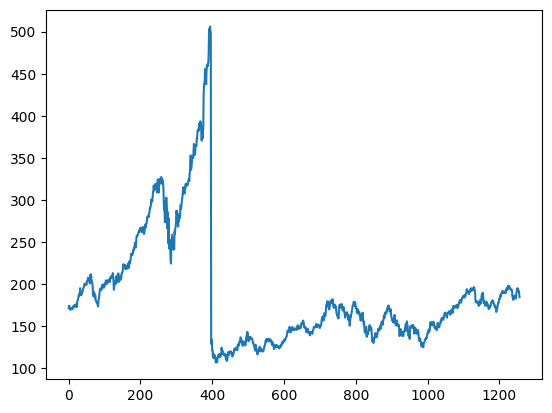

In [ ]:
'''Plot the chart based on closing value of apple stock'''
plt.plot(closing_set)

Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min
where min, max = feature_range.

This transformation is often used as an alternative to zero mean, unit variance scaling.

MinMaxScaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range, where the largest occurring data point corresponds to the maximum value and the smallest one corresponds to the minimum value.

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
closing_set=scaler.fit_transform(np.array(closing_set).reshape(-1,1))

In [ ]:
'''Analyzing the shape after reshaping'''
closing_set.shape

(1257, 1)

In [ ]:
'''Scaled data'''
closing_set

array([[0.16132749],
       [0.16866625],
       [0.16881653],
       ...,
       [0.21262367],
       [0.20338134],
       [0.19426425]])

Here we chose train size is 0.65 based on that we create training size and test size. Train data and test data divided from closing set based on training size and test size.

In [ ]:
training_size=int(len(closing_set)*0.65)
test_size=len(closing_set)-training_size
train_data,test_data=closing_set[0:training_size,:1],closing_set[training_size:len(closing_set),:1]

In [ ]:
'''Checking training and testing size'''
training_size,test_size

(817, 440)

In [ ]:
'''Checking train data shape'''
train_data.shape

(817, 1)

We’ll create our training data by creating sequences of stock prices and their corresponding labels. Each sequence will contain the stock prices of the previous 100 days.

In [ ]:
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX),np.array(dataY)

In [ ]:
time_step=100
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test=create_dataset(test_data,time_step)

In [ ]:
print(x_train)
x_train.shape,y_train.shape

[[0.16132749 0.16866625 0.16881653 ... 0.22978084 0.2222417  0.23283657]
 [0.16866625 0.16881653 0.16055103 ... 0.2222417  0.23283657 0.23268629]
 [0.16881653 0.16055103 0.15922354 ... 0.23283657 0.23268629 0.22812774]
 ...
 [0.14509706 0.14256731 0.1377583  ... 0.14922981 0.13763306 0.14036318]
 [0.14256731 0.1377583  0.14647464 ... 0.13763306 0.14036318 0.12513463]
 [0.1377583  0.14647464 0.16115216 ... 0.14036318 0.12513463 0.12455855]]


((716, 100), (716,))

In [ ]:
'''Resahping train and test data to 3 dimensional for applying model'''
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

# Model Selection & Development


Long Short-Term Memory (LSTM) is a type of computer program that is designed to analyze and understand data that has long-term dependencies. It is often used in analyzing time series data, such as stock market prices. Time series data refers to the sequence of past stock prices and other financial data, and LSTM can use this data to identify patterns and trends that can be used to predict future stock prices. LSTM is particularly useful in analyzing stock market data because it can handle data with multiple input and output timesteps. For example, a company's stock price may be influenced by various factors such as economic indicators, market trends, and company-specific news. These factors may have a direct or indirect impact on the stock price, and the LSTM model is able to capture these relationships and use them to make more accurate predictions. Overall, LSTM and time series analysis can be a powerful tools for investors who want to make informed investment decisions based on the analysis of stock market data

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))


In [ ]:
'''Compiling model'''
model.compile(loss='mse',optimizer='adam')

In [ ]:
'''Analyzing model'''
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Training

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
12/12 [==============================] - 6s 173ms/step - loss: 0.0351 - val_loss: 8.0618e-04
Epoch 2/10
12/12 [==============================] - 1s 103ms/step - loss: 0.0128 - val_loss: 8.1561e-04
Epoch 3/10
12/12 [==============================] - 1s 102ms/step - loss: 0.0092 - val_loss: 3.3907e-04
Epoch 4/10
12/12 [==============================] - 1s 102ms/step - loss: 0.0094 - val_loss: 5.3569e-04
Epoch 5/10
12/12 [==============================] - 1s 102ms/step - loss: 0.0084 - val_loss: 4.3132e-04
Epoch 6/10
12/12 [==============================] - 1s 125ms/step - loss: 0.0080 - val_loss: 3.8722e-04
Epoch 7/10
12/12 [==============================] - 1s 110ms/step - loss: 0.0060 - val_loss: 3.5153e-04
Epoch 8/10
12/12 [==============================] - 1s 101ms/step - loss: 0.0062 - val_loss: 5.6924e-04
Epoch 9/10
12/12 [==============================] - 1s 102ms/step - loss: 0.0055 - val_loss: 2.7402e-04
Epoch 10/10
12/12 [==============================] - 1s 102ms/st

# Model Evaluation

In [ ]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

11/11 [==============================] - 0s 19ms/step


In [ ]:
'''Reverse scaling the predicted values'''
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
'''Calculating root mean square error for train data'''
math.sqrt(mean_squared_error(y_train,train_predict))

215.64401686740067

In [ ]:
math.sqrt(mean_squared_error(y_test,test_predict))

170.69038536804715

# Visualization of actual and predicted values

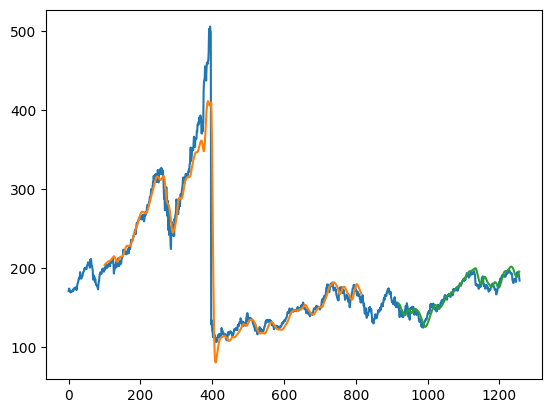

In [ ]:
trainPredictPlot=np.empty_like(closing_set)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step,:]=train_predict

testPredictPlot=np.empty_like(closing_set)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(closing_set)-1, :]= test_predict

plt.plot(scaler.inverse_transform(closing_set))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


# Future Stock Price Predction

In [ ]:
len(test_data)

440

In [ ]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.17868503443957418,
 0.18164057608015027,
 0.17397620538509706,
 0.16874139010644956,
 0.17257357545397617,
 0.17074514715090788,
 0.17815904821540385,
 0.18091421415153408,
 0.17194740137758296,
 0.16804007514088914,
 0.17019411396368184,
 0.173425172197871,
 0.16310582341891044,
 0.15927363807138384,
 0.15992485911083276,
 0.16122730118973072,
 0.16758922980588598,
 0.16420788979336254,
 0.1673638071383844,
 0.17049467752035058,
 0.17695679398872882,
 0.18071383844708827,
 0.17921102066374445,
 0.18274264245460237,
 0.1850219160926737,
 0.18036318096430803,
 0.18003757044458357,
 0.17610519724483403,
 0.17282404508453347,
 0.17187226048841575,
 0.1654101440200375,
 0.1657107075767063,
 0.1668127739511584,
 0.16095178459611764,
 0.15040701314965554,
 0.1537382592360676,
 0.15892298058860355,
 0.16012523481527863,
 0.16814026299311202,
 0.17715716969317463,
 0.17485284909204757,
 0.1813149655604257,
 0.18780212899185966,
 0.19048215403882274,
 0.1892798998121477,
 0.19927363807138382

In [ ]:
lst_output=[]
n_steps=100
i=0
while(i<30):
  if(len(temp_input))>100:
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input=x_input.reshape((1,n_steps,1))

    yhat = model.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input = x_input.reshape(1,n_steps,1)
    yhat = model.predict(x_input,verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1
print(lst_output)

[0.22637264]
101
1 day input [0.18164058 0.17397621 0.16874139 0.17257358 0.17074515 0.17815905
 0.18091421 0.1719474  0.16804008 0.17019411 0.17342517 0.16310582
 0.15927364 0.15992486 0.1612273  0.16758923 0.16420789 0.16736381
 0.17049468 0.17695679 0.18071384 0.17921102 0.18274264 0.18502192
 0.18036318 0.18003757 0.1761052  0.17282405 0.17187226 0.16541014
 0.16571071 0.16681277 0.16095178 0.15040701 0.15373826 0.15892298
 0.16012523 0.16814026 0.17715717 0.17485285 0.18131497 0.18780213
 0.19048215 0.1892799  0.19927364 0.19526612 0.20187852 0.2033062
 0.20756418 0.20751409 0.21192235 0.20989355 0.2115717  0.2082154
 0.20776456 0.20929242 0.20671259 0.20816531 0.21139637 0.20686287
 0.21685661 0.21410144 0.2189856  0.22259236 0.21625548 0.22008766
 0.22822793 0.22860363 0.2272511  0.22304321 0.22567314 0.22038823
 0.22001252 0.21730745 0.21592987 0.21618034 0.21725736 0.21462743
 0.19737007 0.19388854 0.18802755 0.18619912 0.19716969 0.19611772
 0.19874765 0.19724483 0.19807138 0

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
df1=closing_set.tolist()
df1.extend(lst_output)

# Visualization of Future Predicted Prices

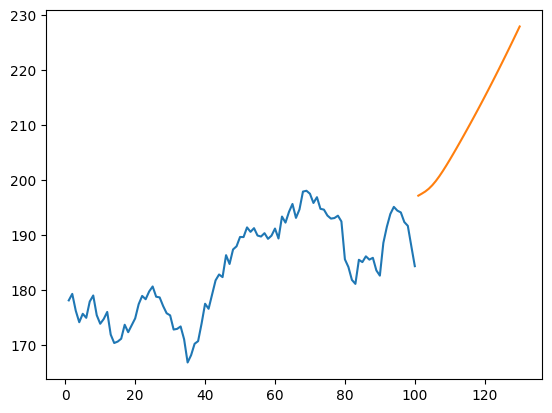

In [ ]:
plt.plot(day_new,scaler.inverse_transform(closing_set[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

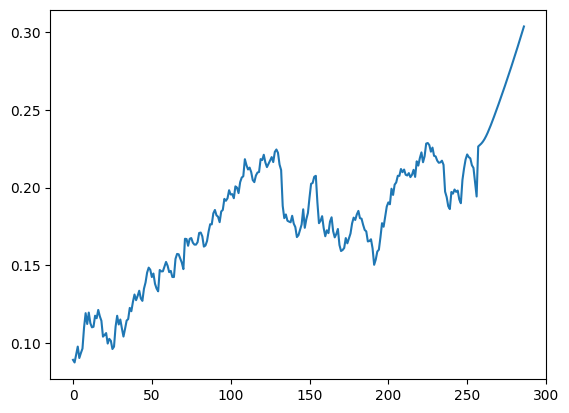

In [ ]:
plt.plot(df1[1000:])